In [1]:
import torch
import numpy as np
from drlqap.qap import GraphAssignmentProblem
from drlqap import nn_configs, taskgenerators
import drlqap
from drlqap.simplesolver import solve_qap_backtracking
import matplotlib.pyplot as plt
import matplotlib
import bokeh
from bokeh.plotting import figure, show, gridplot
import drlqap.nn
from collections import defaultdict
import pandas as pd
from drlqap.nnutils import FullyConnected
from pathlib import Path

In [2]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
# clear results
results = defaultdict(dict)

# Setup

In [4]:
plotpath = Path("../paper/plots/gnnembeddings/")

In [5]:
w = 32
n = 12
out = n
depth = 2

In [6]:
class TestNet(torch.nn.Module):
    def __init__(self, conv_norm, num_layers):
        super().__init__()
        self.conv_norm = conv_norm
        self.num_layers = num_layers
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            message_in_size = 1 if i == 0 else 1 + w
            transform_depth = 0 if i < num_layers - 1 else 2
            self.layers.append(drlqap.nn.ConvLayer(
                edge_encoder=FullyConnected(message_in_size, w, w, depth, activation=torch.nn.LeakyReLU),
                transformation=FullyConnected(w, w, w, transform_depth, activation=torch.nn.LeakyReLU),
                norm=conv_norm,
                aggregation='sum'
            ))
        self.out_linear = torch.nn.Linear(w, out)
        
    def forward(self, connectivity):
        edges = connectivity
        nodes = None
        for layer in self.layers:
            nodes = layer(edges, nodes)
        return self.out_linear(nodes)

nets = {
    "none": lambda d: TestNet(conv_norm=None, num_layers=d),
    "bn":   lambda d: TestNet(conv_norm=torch.nn.BatchNorm1d(num_features=w, track_running_stats=False, affine=False), num_layers=d),
    "kmn":   lambda d: TestNet(conv_norm=drlqap.nn.KeepMeanNorm(), num_layers=d),
    "tmn":  lambda d: TestNet(conv_norm=drlqap.nn.TransformedMeanNorm(w), num_layers=d),
    "ms":   lambda d: TestNet(conv_norm=drlqap.nn.MeanSeparationLayer(w), num_layers=d),
    "ms100x":   lambda d: TestNet(drlqap.nn.MeanSeparationLayer(w, residual_scale=100), num_layers=d),
}

In [7]:
in_matrix = torch.rand(n, n)
#tri = in_matrix.triu(diagonal=1)
#in_matrix = tri + tri.transpose(0, 1)
in_matrix = in_matrix.unsqueeze(2)
in_matrix.squeeze()

tensor([[0.3296, 0.0036, 0.5499, 0.2985, 0.4296, 0.0393, 0.5032, 0.9269, 0.7573,
         0.3691, 0.1988, 0.9622],
        [0.1637, 0.8475, 0.4672, 0.3064, 0.6576, 0.5599, 0.9087, 0.7133, 0.4050,
         0.6004, 0.5725, 0.0820],
        [0.1112, 0.0364, 0.7532, 0.1263, 0.7482, 0.6384, 0.9348, 0.2155, 0.8380,
         0.3250, 0.5946, 0.8241],
        [0.3090, 0.7793, 0.8492, 0.9842, 0.1183, 0.1948, 0.0643, 0.1545, 0.5634,
         0.2671, 0.0644, 0.5887],
        [0.2345, 0.0267, 0.4769, 0.2941, 0.6151, 0.1594, 0.9551, 0.3762, 0.1169,
         0.5699, 0.3983, 0.8542],
        [0.1123, 0.3532, 0.0842, 0.3896, 0.4668, 0.0631, 0.0568, 0.6058, 0.8077,
         0.4712, 0.2408, 0.8986],
        [0.1359, 0.1221, 0.0234, 0.6284, 0.5432, 0.3291, 0.7793, 0.8416, 0.1629,
         0.9875, 0.0888, 0.2607],
        [0.3927, 0.6770, 0.8456, 0.8654, 0.5341, 0.3147, 0.8636, 0.5071, 0.9257,
         0.0376, 0.6156, 0.5990],
        [0.7723, 0.3598, 0.1838, 0.6265, 0.5784, 0.4932, 0.0497, 0.0179, 0.9585,

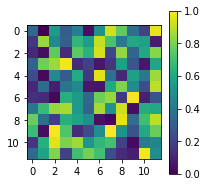

In [32]:
plt.figure(figsize=(3,3))
plt.imshow(in_matrix, vmin=0,  vmax=1)
plt.xticks(range(0, n, 2))
plt.yticks(range(0, n, 2))
plt.colorbar()
plt.savefig(plotpath / "in_matrix.pdf", bbox_inches="tight")

# Test Networks

In [9]:
def create_net(name, base=None, seed=12345, layers=1):
    torch.manual_seed(seed)
    net = nets[name](layers)
    if base:
        missing, unexpected = net.load_state_dict(base.state_dict(), strict=False)
    return net

In [10]:
def show_output(net, x):
    print(net.layers[0].norm)
    with torch.no_grad():
        net_output = net(x)
    plt.imshow(net_output)
    plt.xlabel("Embedding index")
    plt.ylabel("Node")
    plt.colorbar()
    plt.show()

None


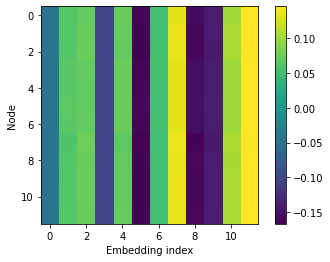

BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)


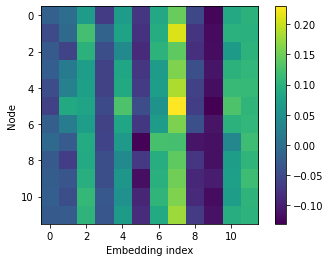

KeepMeanNorm()


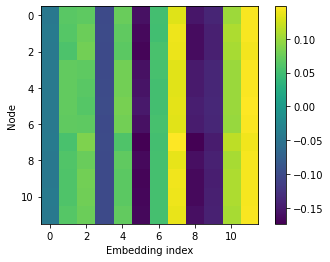

TransformedMeanNorm(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
)


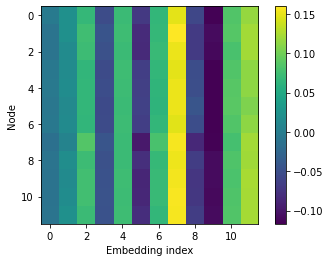

MeanSeparationLayer(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
  (residual_linear): Linear(in_features=32, out_features=32, bias=True)
)


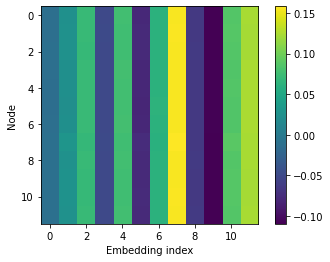

MeanSeparationLayer(
  (mean_linear): Linear(in_features=32, out_features=32, bias=True)
  (residual_linear): Linear(in_features=32, out_features=32, bias=True)
)


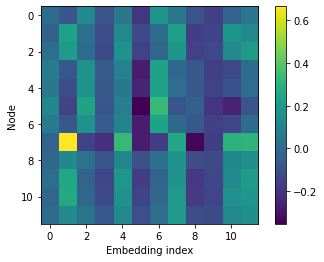

In [34]:
base_net = create_net("none")
show_output(create_net("none", base=base_net), in_matrix)
show_output(create_net("bn", base=base_net), in_matrix)
show_output(create_net("kmn", base=base_net), in_matrix)
show_output(create_net("tmn", base=base_net), in_matrix)
show_output(create_net("ms", base=base_net), in_matrix)
show_output(create_net("ms100x", base=base_net), in_matrix)

# Target Matrix

tensor(0.0833)


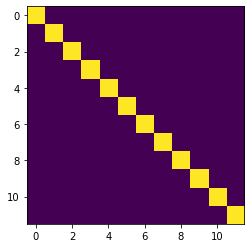

In [12]:
#target_matrix = torch.rand(n,out)
target_matrix = torch.eye(n,out)
print(target_matrix.mean())
plt.imshow(target_matrix)

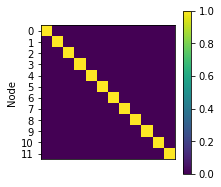

In [36]:
plt.figure(figsize=(3,3))
plt.imshow(target_matrix, vmin=0,  vmax=1)
plt.colorbar()
plt.xticks([])
plt.yticks(range(n))
plt.ylabel("Node")
plt.savefig(plotpath / "target_embeddings.pdf", bbox_inches="tight")

# Train

In [14]:
results = defaultdict(dict)

In [15]:
def train(net, epochs, lr, weight_decay=0):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)   
    losses = []
    target = target_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(in_matrix)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [16]:
repetitions = 4
threshold = 0.03

def find_index_below(values, threshold):
    for i, x in enumerate(values):
        if x < threshold:
            return i
    return None

for seed in range(repetitions):
    for depth in [1,2]:
        base_net = create_net("none", seed=seed, layers=depth)
        for name in nets:
            net = create_net(name, base=base_net, seed=seed, layers=depth)
            losses = train(net, 100, lr=5e-3)
            results[(name, depth)][seed] = (net, losses)
            threshold_steps = find_index_below(losses, threshold)
            print(f"{name, depth} done; {threshold_steps} until {threshold}; final loss: {losses[-1]}")

print("done")

('none', 1) done; None until 0.03; final loss: 0.0552016943693161
('bn', 1) done; 39 until 0.03; final loss: 0.006419099867343903
('kmn', 1) done; None until 0.03; final loss: 0.05568628013134003
('tmn', 1) done; None until 0.03; final loss: 0.032276324927806854
('ms', 1) done; None until 0.03; final loss: 0.03698001801967621
('ms100x', 1) done; 32 until 0.03; final loss: 0.0022661620751023293
('none', 2) done; None until 0.03; final loss: 0.06463334709405899
('bn', 2) done; 25 until 0.03; final loss: 1.2424002306943294e-05
('kmn', 2) done; 86 until 0.03; final loss: 0.022626200690865517
('tmn', 2) done; 54 until 0.03; final loss: 0.002269159536808729
('ms', 2) done; None until 0.03; final loss: 0.03464867174625397
('ms100x', 2) done; 31 until 0.03; final loss: 3.705048584379256e-05
('none', 1) done; None until 0.03; final loss: 0.06880930066108704
('bn', 1) done; 44 until 0.03; final loss: 0.007122861221432686
('kmn', 1) done; None until 0.03; final loss: 0.062408432364463806
('tmn', 

# Loss curves

In [17]:
from bokeh.palettes import Dark2_8
from bokeh.models import Range1d
import itertools

fig = figure()

def moving_average(x, n=100) :
    return np.mean(sliding_window_view(x, window_shape=n), axis=-1)

palette = Dark2_8
average = False
for i, (name, net_runs) in enumerate(results.items()):
    x = range(len(net_runs[0][1]))
    color = palette[i % len(palette)]
    
    if average:
        average_loss = np.mean([run[1] for run in net_runs], axis=0)
        fig.line(x=x, y=average_loss, legend_label=str(name), color=Dark2_5[i])
    else:
        for seed, (net, loss) in net_runs.items():
            fig.line(x=x, y=loss, legend_label=str(name), color=color)

fig.y_range = Range1d(0,0.2)
fig.legend.click_policy = "hide"
show(fig)

In [18]:
def aggregate(df, key, window, agg):
        return df.groupby(key, sort=False).aggregate(agg).transpose().rolling(window).mean()

def generate_variation_plot(df, key, window, labels):
    mean = aggregate(df, key, window, 'mean')
    upper = aggregate(df, key, window, 'max')
    lower = aggregate(df, key, window, 'min')
    cmap = matplotlib.cm.get_cmap('tab10')
    count = len(mean.columns)
    for i, (col, label) in enumerate(labels.items()):
        color = cmap(i)
        #plt.fill_between(mean[col].index, lower[col], upper[col], alpha=0.1, color=color)
        matching_indices = (df.index.get_level_values(key) == col)
        individuals = df[matching_indices].transpose().rolling(window).mean()
        for i in individuals:
            plt.plot(individuals[i], alpha=0.1, linewidth=4, color=color, zorder=1)
        plt.plot(mean[col], label=label, color=color, linewidth=1.5, alpha=0.9, zorder=2)

In [19]:
labels = {
    'none': 'No norm',
    'kmn': 'Keep Mean',
    'tmn': 'Transformed Mean',
    'ms': 'Mean Separation',
    'ms100x': 'Mean Separation (scaled x100)',
    'bn': 'PairNorm',
}

In [20]:
values = [values for _, net_results in results.items() for _, (net, values) in net_results.items()]
indices = [(name, depth, seed) for (name, depth), net_results in results.items() for seed, (net, values) in net_results.items()]
df = pd.DataFrame(values, index=pd.MultiIndex.from_tuples(indices, names=['name', 'depth', 'seed']))

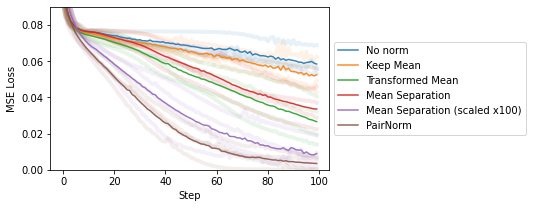

In [21]:
plt.figure(figsize=(5,3))
generate_variation_plot(df.query("depth == 1"), 'name', 1, labels)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.ylim(0, 0.09)
plt.savefig(plotpath / "mse.pdf", bbox_inches="tight")

# Outputs

In [35]:
grid = []

for name, net_results in results.items():
    gridrow = []
    for i, (net, losses) in net_results.items():
        with torch.no_grad():
            net_output = net(in_matrix)
        data = dict(value=[net_output.numpy()])
        fig = figure(
            title=str(name),
            tools="hover",
            tooltips=[("Value", "@value")]
        )
        fig.image(
            source=data, 
            image="value",
            x=0, y=0, 
            dw=out, dh=n, 
            color_mapper=bokeh.models.LinearColorMapper(low=0, high=1, palette="Viridis256")
        )
        gridrow.append(fig)
    grid.append(gridrow)
show(gridplot(grid, sizing_mode="scale_width"))

In [23]:
def plot_output(name, depth, seed=0):
    net, values = results[(name, depth)][seed]
    with torch.no_grad():
        net_out = net(in_matrix)
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks(range(n))
    plt.ylabel("Node")
    plt.imshow(net_out, vmin=0, vmax=1)

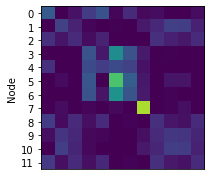

In [24]:
plot_output("none", 1)
plt.savefig(plotpath / "embeddings_none.pdf", bbox_inches="tight")

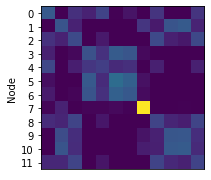

In [25]:
plot_output("kmn", 1)
plt.savefig(plotpath / "embeddings_kmn.pdf", bbox_inches="tight")

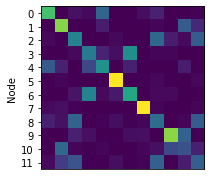

In [26]:
plot_output("tmn", 1)
plt.savefig(plotpath / "embeddings_tmn.pdf", bbox_inches="tight")

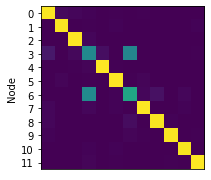

In [27]:
plot_output("bn", 1)
plt.savefig(plotpath / "embeddings_bn.pdf", bbox_inches="tight")

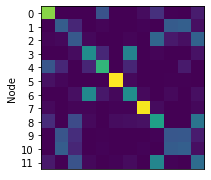

In [28]:
plot_output("ms", 1)
plt.savefig(plotpath / "embeddings_ms.pdf", bbox_inches="tight")

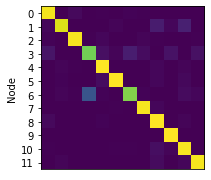

In [29]:
plot_output("ms100x", 1)
plt.savefig(plotpath / "embeddings_ms100x.pdf", bbox_inches="tight")